In [134]:
#Importing packages
import pandas as pd
import numpy as np  
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [135]:
#Reading in training data
hndl = open("titanic/train.csv")
dftr = pd.read_csv(hndl)
dftr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is a brief view of the training data available to us. From all available fields we have to find out which of these are relevant to the survivability of the passengers on board. We can see that the Name, Ticket and PassengerID all serve the same purpose of identifying the passenger. Therefore, we will eventually drop ticket and PassengerID.

In [136]:
#Overall survival rate
print(dftr['Survived'].value_counts(normalize=True))
#Survival rate as per class
print(dftr['Survived'].groupby(dftr['Pclass']).mean())
#Survival rate as per sex
print(dftr['Survived'].groupby(dftr['Sex']).mean())

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


From above data we an see that <b>sex</b> and <b>ticket class</b> have a significant effect on the survivability of passengers. Thus, these are data fields we should include in our model.

In [137]:
#Splitting into 5 groups and showing their average survivability
dftr['Survived'].groupby(pd.qcut(dftr['Age'],6)).mean()

Age
(0.419, 18.0]    0.503597
(18.0, 23.0]     0.308411
(23.0, 28.0]     0.387931
(28.0, 34.0]     0.413793
(34.0, 44.0]     0.421488
(44.0, 80.0]     0.373913
Name: Survived, dtype: float64

Looks like there is a pretty even distribution of survivability as per age. Other than non adults, who have survived more. Thus age might play an important part in the survivability and should be included.

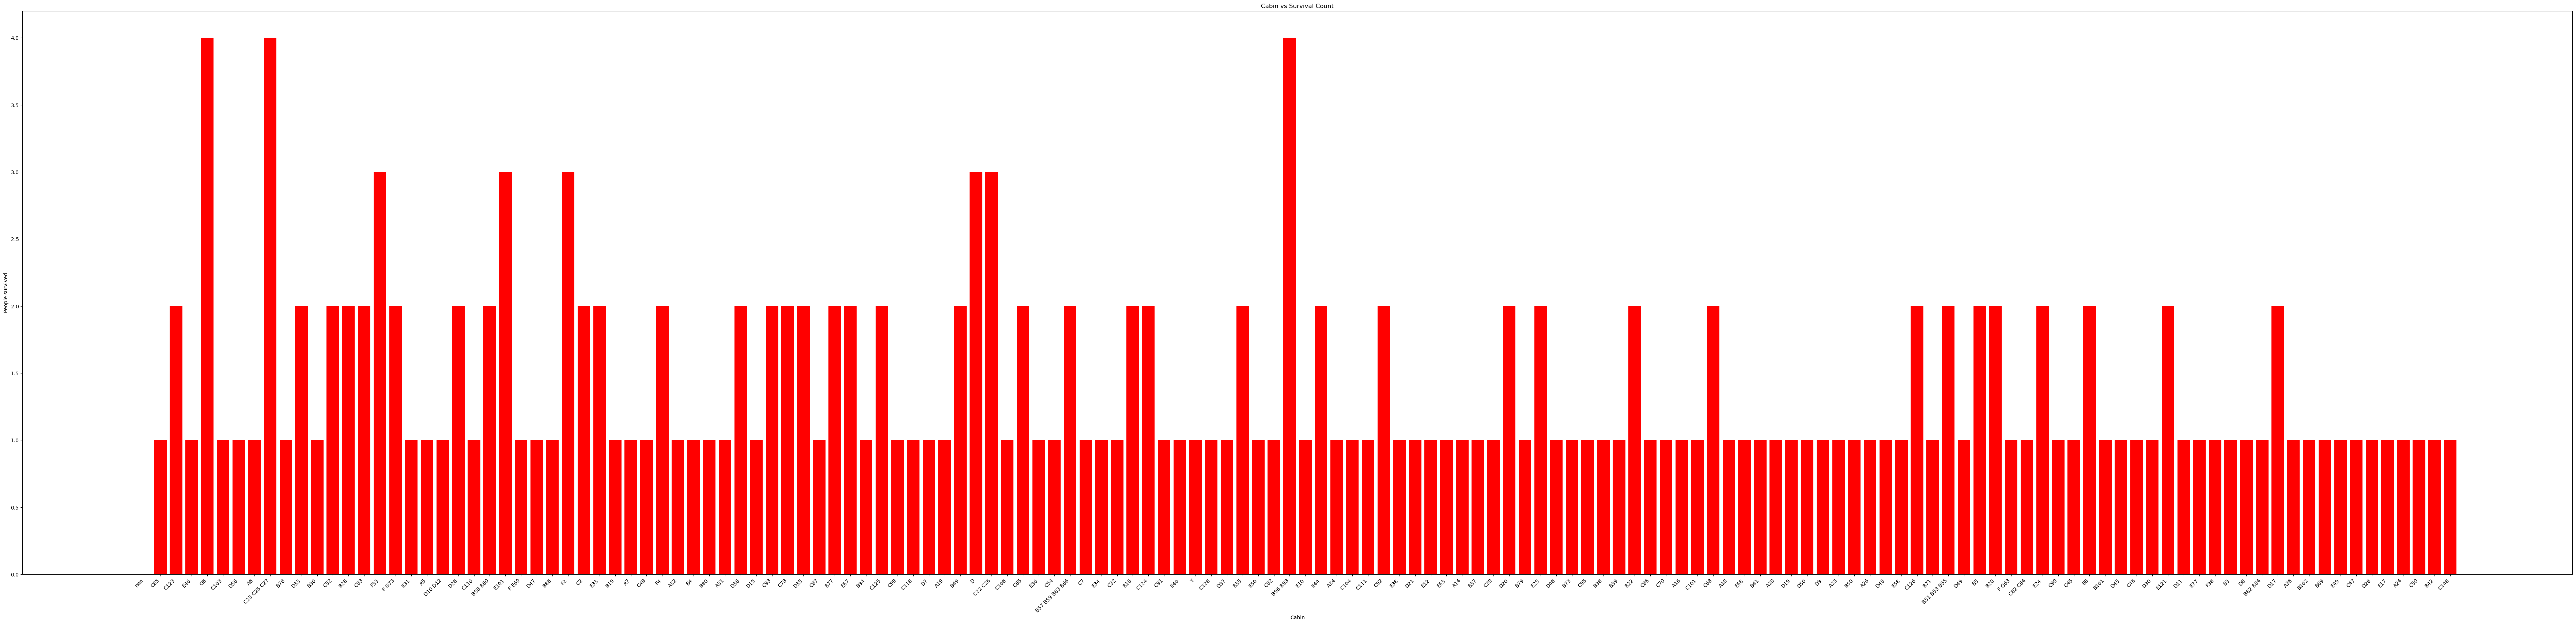

In [138]:
# Getting data of the number of passengers survived in each cabin 
cab = dftr.Cabin.unique().astype(str)
survival_counts = []

for cabin in cab:
    i=dftr.loc[dftr['Cabin']==cabin]
    count=i.shape[0]
    survival_counts.append(count)

# Plotting the Data 
plt.figure(figsize=(90,20))
plt.bar(cab,survival_counts,color='red')
plt.xlabel('Cabin')
plt.ylabel('People survived')
plt.xticks(rotation=45,ha="right")
plt.title("Cabin vs Survival Count")

plt.show()

Here we see that, the cabin number does not have a significant effect on the survivability. Thus, for the sake of our preliminary model we will drop this as well. Additionally, the point of embarkment should not have a measurable effect as well, thus we will drop that too. Name, Ticket and Passenger ID are all identifiers and only one of them need to be retained. Passenger ID is the shortest and thus will be retained.

In [139]:
#Combining ParCh and SibSp into a single column (Family) and removing OG columns
dftr['Fam'] = dftr[['SibSp', 'Parch']].sum(axis =1)
#Dropping Name, Embarked, Ticket and storing data in dftrm
dftrm=dftr.drop(['Name','Embarked','Ticket','Cabin', 'Fare', 'SibSp', 'Parch'],axis=1)
#Removing rows with NA values
dftrm = dftrm.dropna()

These are our resultant fields upon which we will perform regression.

In [140]:
#Imporatant statistics
dftrm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,714.0,448.582633,259.119524,1.00,222.250,445.0,677.75,891.0
Survived,714.0,0.406162,0.491460,0.00,0.000,0.0,1.00,1.0
Pclass,714.0,2.236695,0.838250,1.00,1.000,2.0,3.00,3.0
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.00,80.0
Fam,714.0,0.943978,1.483788,0.00,0.000,0.0,1.00,7.0


As we can see from above the input fields have a wide variety of ranges. The next step is to perform <b>normalisation</b>. This will be important for the models stability. Additionally, we must replace categorical string variables with binary variables.

In [141]:
#Creating clone for normalisation
dftrm_normal = dftrm.copy()
#Dealing with categorical variables
dftrm_normal['Sex'] = dftrm_normal['Sex'].replace({'male': 1, 'female': 0})
#Normalisation function
def normalise(A):
    for field in A:
        if field in ['Age']:
            A[field] = (A[field]/A[field].abs().max())
        else: 
            continue
    return A
#Normalising
dftrm_normal = normalise(dftrm_normal)
#View
dftrm_normal.head()

,PassengerId,Survived,Pclass,Sex,Age,Fam
0,1,0,3,1,0.2750,1
1,2,1,1,0,0.4750,1
2,3,1,3,0,0.3250,0
3,4,1,1,0,0.4375,1
4,5,0,3,1,0.4375,0


This is what we will be taking into out final model.

In [142]:
#Creating the model
#Taking relevant columns into the model
X = dftrm_normal[['Sex', 'Age', 'Pclass', 'Fam']].to_numpy()
Y = dftrm_normal[['Survived']].to_numpy()
#Training testing split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
#Fitting to decision tree
clf = RandomForestClassifier(n_estimators= 100, bootstrap=True, random_state= 13, max_depth=5, max_features=2)
clf.fit(X_train,Y_train.ravel())
#Getting predictions
Y_test_out = clf.predict(X_test)

Metrics to evaluate model performance.

In [143]:
#Accuracy score
print("Accuracy of model:", accuracy_score(Y_test, Y_test_out))
#Report
#print(classification_report(Y_test, Y_test_out))
#Feature importances
fimp = clf.feature_importances_
print(f"Feature importances are as follows {fimp}")

Accuracy of model: 0.8268156424581006
Feature importances are as follows [0.49686461 0.18956573 0.22167869 0.09189098]


While these are not the best metrics to measure model performance, they can give an elementary idea which is sufficient for the preliminary model. Now to create the output DF.

In [144]:
#Reading in CSV
hndl = open("titanic/test.csv")
dftr = pd.read_csv(hndl)
#Formatting + Preparing for model input
dftr['Fam'] = dftr[['SibSp', 'Parch']].sum(axis =1) #Merging SibSp and Parch
dftrm=dftr.drop(['Name','Embarked','Ticket','Cabin', 'Fare', 'SibSp', 'Parch'],axis=1) #Dropping irrelevent variables
dftrm_normal = dftrm.copy() #Creating copy to normalise
dftrm_normal['Sex'] = dftrm_normal['Sex'].replace({'male': 1, 'female': 0}) #Replacing string catefgorical variables with binary ones
dftrm_normal = normalise(dftrm_normal) #Normalising
#Filling in Na values
dftrm_normal.fillna(0,inplace=True)
#Creating input array
X_sub = dftrm_normal[['Sex', 'Age', 'Pclass', 'Fam']].to_numpy() 
#Creating Outputs
Y_sub = clf.predict(X_sub)
#Creating output DF
submission = pd.DataFrame({'PassengerId': dftrm_normal['PassengerId'], 'Survived': Y_sub})
#Creating output CSV
submission.to_csv("submission.csv",index=False)

This is going to be our submission, lets see how it does.